In [1]:
import pandas as pd
import torch
from torch import nn
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn import *
import scipy
import time

#  Data Processing

In [2]:
q = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-queries.csv', sep=';', dtype={'searchstring.tokens': 'O'})
# q['searchstring.tokens'] = q['searchstring.tokens'].astype('O')
v = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-item-views.csv', sep=';')
c = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-clicks.csv', sep=';')
p = pd.read_csv('./data/diginetica/dataset-train-diginetica/train-purchases.csv', sep=';')
products = pd.read_csv('./data/diginetica/dataset-train-diginetica/products.csv', sep=';')
product_cat = pd.read_csv('./data/diginetica/dataset-train-diginetica/product-categories.csv', sep=';')

In [3]:
print(f'q:           {list(q.columns)}')
print(f'v:           {list(v.columns)}')
print(f'c:           {list(c.columns)}')
print(f'p:           {list(p.columns)}')
print(f'products:    {list(products.columns)}')
print(f'product_cat: {list(product_cat.columns)}')


q:           ['queryId', 'sessionId', 'userId', 'timeframe', 'duration', 'eventdate', 'searchstring.tokens', 'categoryId', 'items', 'is.test']
v:           ['sessionId', 'userId', 'itemId', 'timeframe', 'eventdate']
c:           ['queryId', 'timeframe', 'itemId']
p:           ['sessionId', 'userId', 'timeframe', 'eventdate', 'ordernumber', 'itemId']
products:    ['itemId', 'pricelog2', 'product.name.tokens']
product_cat: ['itemId', 'categoryId']


In [4]:
qq = q.iloc[:10_000].copy()

In [5]:
qi = qq.copy()
qi['items'] = qi['items'].str.split(',')
qi = qi.explode('items')
qi['pos'] = 1
qi['pos'] = qi.groupby('queryId')['pos'].cumsum()
qi = qi.rename(columns={'items': 'itemId'})
qi['itemId'] = qi['itemId'].astype(int)
qi = qi.rename(columns={'duration': 'duration_query', 'categoryId': 'categoryId_query'})
# clicks
qi = pd.merge(qi.rename(columns={'timeframe': 'timeframe_query', 'eventdate': 'eventdate_query'}), c.rename(columns={'timeframe': 'timeframe_click'}), how='left', on=['queryId', 'itemId'])
qi['clicked'] = qi['timeframe_click'].notna() * 1
# views (doesn't merge well)
# qi = pd.merge(qi, v.rename(columns={'timeframe': 'timeframe_view', 'eventdate': 'eventdate_view'}), how='left', on=['sessionId', 'userId', 'itemId'])
# purchases
qi = pd.merge(qi, p.rename(columns={'timeframe': 'timeframe_purchase', 'eventdate': 'eventdate_purchase'}), how='left', on=['userId', 'sessionId', 'itemId'])
qi['purchased'] = qi['timeframe_purchase'].notna()
# product prices
qi = pd.merge(qi, products, how='left', on=['itemId'])
# product cat
qi = pd.merge(qi, product_cat.rename(columns={'categoryId': 'categoryId_product'}), how='left', on=['itemId'])
# query totals
totals = qi.groupby('queryId')[['clicked', 'purchased']].sum().reset_index().rename(columns={'clicked':'clicks_query', 'purchased':'purchases_query', })
qi = pd.merge(qi, totals, on=['queryId'])
qi.loc[qi['searchstring.tokens'].isna(), 'searchstring.tokens'] = ''
qi['searchstring.tokens'] = qi['searchstring.tokens'].str.split(',')
qi['product.name.tokens'] = qi['product.name.tokens'].str.split(',')
# qi = qi.drop(columns=['queryId', 'sessionId', 'userId', 'timeframe_query', 'timeframe_click', 'timeframe_purchase', 'eventdate_purchase', 'ordernumber', 'clicks_query', 'purchases_query', 'is.test', 'pos', 'purchased', 'eventdate_query'])
qi = qi.drop(columns=['queryId', 'sessionId', 'userId', 'timeframe_query', 'timeframe_click', 'timeframe_purchase', 'eventdate_purchase', 'ordernumber', 'clicks_query', 'purchases_query', 'is.test', 'pos', 'eventdate_query'])
qi = qi.drop(columns=['product.name.tokens', 'searchstring.tokens'])
# qi = qi.drop(columns=['categoryId_query', 'categoryId_product'])

In [6]:
pi = pd.DataFrame()
pi['n'] = qi.groupby('itemId').size()
pi['clicked'] = qi.groupby('itemId')['clicked'].sum()
pi['price'] = qi.groupby('itemId')['pricelog2'].mean()
pi['p_click'] = pi['clicked'] / pi['n']
pi = pi.reset_index()
# pi.loc[pi['clicked'] > 0, 'l_ctr'] = np.log(pi['clicked'] / pi['n'])
# pi.loc[pi['clicked'] == 0, 'l_ctr'] = 0

# pi.loc[pi['purchased'] > 0, 'l_gmv'] = pi['price'] * np.log(pi['purchased'] / pi['n'])
# pi.loc[pi['purchased'] > 0, 'l_gmv'] = pi['price'] * np.log(pi['purchased'] / pi['n']) + np.log(pi['purchased'] / pi['clicked'])
# pi.loc[pi['purchased'] == 0, 'l_gmv'] = 0
qi = pd.merge(qi, pi[['itemId', 'p_click']], on=['itemId'], how='left')

In [7]:
# one hot for single cats
qi = qi.merge(pd.get_dummies(qi['itemId'], prefix='itemId'), left_index=True, right_index=True)
qi = qi.merge(pd.get_dummies(qi['categoryId_query'], prefix='categoryId_query'), left_index=True, right_index=True)
qi = qi.merge(pd.get_dummies(qi['categoryId_product'], prefix='categoryId_product'), left_index=True, right_index=True)
qi = qi.drop(columns=['categoryId_query', 'categoryId_product', 'itemId'])
# one hot for cat lists
# pd.get_dummies(pd.DataFrame(qi['searchstring.tokens'].values.tolist()), prefix_sep='', prefix='')
# pd.get_dummies(pd.DataFrame(qi['product.name.tokens'].values.tolist()), prefix_sep='', prefix='')
top5itemId = qi.filter(like='itemId').sum().sort_values(ascending=False).iloc[:5].index.tolist()
top5categoryId_query = qi.filter(like='categoryId_query').sum().sort_values(ascending=False).iloc[:5].index.tolist()
top5categoryId_product = qi.filter(like='categoryId_product').sum().sort_values(ascending=False).iloc[:5].index.tolist()
qi = qi[['duration_query', 'clicked', 'pricelog2', 'p_click'] + top5itemId + top5categoryId_query + top5categoryId_product]
#fix inputs (top n categories)

In [8]:
x = qi.drop(columns=['clicked', 'p_click'])
y = qi['clicked'] * 1

In [9]:
x_train, x_test_orig, y_train, y_test = sklearn.model_selection.train_test_split(x,y,shuffle=True,train_size=0.70)
y_train = y_train.to_frame('y')
y_test = y_test.to_frame('y')

In [10]:
x_scaler = sklearn.preprocessing.StandardScaler()
# y_scaler = sklearn.preprocessing.StandardScaler()

x_train = pd.DataFrame(x_scaler.fit_transform(x_train),index = x_train.index, columns = x_train.columns)
x_test =  pd.DataFrame(x_scaler.transform(x_test_orig),index = x_test_orig.index, columns = x_test_orig.columns)
# y_train = pd.DataFrame(y_scaler.fit_transform(y_train),index = y_train.index, columns = y_train.columns)
# y_test =  pd.DataFrame(y_scaler.transform(y_test),index = y_test.index, columns = y_test.columns)

In [11]:
x_train = torch.tensor(x_train.values).float()
x_test = torch.tensor(x_test.values).float()
y_train = torch.tensor(y_train.values).float()
y_test = torch.tensor(y_test.values).float()

# NN setup

In [12]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x,y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return {
            'x': self.x[idx,:],
            'y': self.y[idx,:],
        }

In [13]:
class SimpleNN(torch.nn.Module):
    def __init__(self,insize,linlayers):
        super(type(self),self).__init__()
        self.linlayers_size = linlayers
        self.layers=[]
        
        prev = insize
        for curlayersize in self.linlayers_size:
            self.layers.append(torch.nn.Linear(prev,curlayersize))
            self.layers.append(torch.nn.ReLU())
            prev = curlayersize
        self.layers.append(torch.nn.Linear(self.linlayers_size[-1],1,bias=True))
        # self.layers.append(torch.nn.Sigmoid())
        self.layers = torch.nn.Sequential(*self.layers)
        
    def forward(self,x):
        x = self.layers(x)
        return x

In [14]:
for i in range(8,16,1):
    print(f"{i:>3}: {2**i:<5}, {x_train.shape[0]/(2**i):.1f} iter")

  8: 256  , 523.2 iter
  9: 512  , 261.6 iter
 10: 1024 , 130.8 iter
 11: 2048 , 65.4 iter
 12: 4096 , 32.7 iter
 13: 8192 , 16.4 iter
 14: 16384, 8.2 iter
 15: 32768, 4.1 iter


# Train Params

In [15]:
# LOSS

def L2Loss(model):
    return sum(p.pow(2.0).sum() for p in model.parameters())

def ctr_loss(x, p_click, p_click_hat):
    # binary cross entropy
    m = nn.Sigmoid()
    loss = nn.BCELoss()
    input = p_click_hat
    target = p_click
    output = loss(m(input), target)
    return output

def gmv_loss(x, p_click, p_click_hat):
    # binary cross entropy
    m = nn.Sigmoid()
    loss = nn.BCELoss()
    input = p_click_hat
    target = p_click
    output = loss(m(input * x[:,1].unsqueeze(1)), target)
    return output

# losses
Lfx = {
    0:ctr_loss,
    1:gmv_loss,
}
L={
    0:None,
    1:None,
}
# loss weights
w = {
    0:1,
    1:1,
}
# boundary conditions (minimum weights)
c = {
    0:0.2,
    1:0.2,
}
grad = {
    0:[],
    1:[],
}

In [16]:
def pareto(w_in,c_in,G_in):
    G = G_in.numpy()
    K,M = G.shape
    c = np.expand_dims(np.array([c_in[i] for i in range(K)]),1)
    w = np.expand_dims(np.array([w_in[i] for i in range(K)]),1)
    #print(f"K: {K}")
    #print(f"M: {M}")
    #print(f"c: {c.shape}")
    #print(f"w: {w.shape}")
    
    # building e
    e = np.ones(w.shape)
    #print(f"e: {e.shape}")
    
    # building M
    GGT = np.matmul(G,G.T)
    #print(f"GGT: {GGT.shape}")
    
    m_top = np.hstack((GGT, e))
    m_bot = np.hstack((e.T, np.zeros((1,1))))
    M = np.vstack((m_top,m_bot))
    #print(f"GGT: {GGT.shape}")
    
    # building z
    z = np.vstack((-np.matmul(GGT,c),1-np.sum(c)))
    #print(f"z: {z.shape}")
    
    # building w_hat
    w_hat = np.linalg.inv(np.matmul(M.T,M)) #(MT * M)**-1
    w_hat = np.matmul(w_hat,M)
    w_hat = np.matmul(w_hat,z)
    w_hat = w_hat[1:]
    
    # at this point, w_hat could be negative, so we have to make them non-negative
    
    return w_hat
#w_hat = pareto(w,c,G)
#display(w_hat)

In [17]:
# from github page
def ASM(hat_w, c_in):
    """
    ref:
    http://ofey.me/papers/Pareto.pdf,
    https://stackoverflow.com/questions/33385898/how-to-include-constraint-to-scipy-nnls-function-solution-so-that-it-sums-to-1
    :param hat_w: # (K,)
    :param c: # (K,)
    :return:
    """
    
    #reformat c
    c = np.expand_dims(np.array([c_in[i] for i in range(2)]),1)
    
    A = np.array([[0 if i != j else 1 for i in range(len(c))] for j in range(len(c))])
    b = hat_w.squeeze()
    x0, _ = scipy.optimize.nnls(A, b)

    def _fn(x, A, b):
        return np.linalg.norm(A.dot(x) - b)

    cons = {'type': 'eq', 'fun': lambda x: np.sum(x) + np.sum(c) - 1}
    bounds = [[0., None] for _ in range(len(hat_w))]
    min_out = scipy.optimize.minimize(_fn, x0, args=(A, b), method='SLSQP', bounds=bounds, constraints=cons)
    new_w = min_out.x + c.squeeze()
    return new_w
#new_w_hat = ASM(w_hat, c)
#new_w_hat

In [18]:
model = SimpleNN(x_train.shape[1],[64])
model

SimpleNN(
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [19]:
param={
    'batch_size':2**14,
    'epochs':1000,
    'optim':torch.optim.Adam(model.parameters(), 0.001),
}

In [20]:
dataset = CustomDataset(x_train,y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=param['batch_size'], shuffle=True)

In [21]:
training={
    'train':{0:[],1:[]},
    'valid':{0:[],1:[]},
    'time':[],
    'w':{
        0:[],
        1:[],
    }
}

def NoneGrad(model):
    for i in model.parameters():
        i.grad=None
        

for e in range(param['epochs']):
    curtime = time.time()
    
    batchloss={0:[],1:[]}
    for b,batch in enumerate(dataloader):
        print(f"e: {e}; b: {b}",end='\r',flush=True)
        
        # -----train-----
        model.train()
        
        # zero out grad
        param['optim'].zero_grad()
        # predict
        y_hat = model.forward(batch['x'])
        # loss
        L[0] = Lfx[0](batch['x'], batch['y'], y_hat)
        L[1] = Lfx[1](batch['x'], batch['y'], y_hat)
        # store loss individually for tracking purposes
        for i in Lfx:
            batchloss[i].append(L[i].detach())
        # gradients w.r.t. each loss
        for i in Lfx:
            L[i].backward(retain_graph=True)
            grad[i]=[j.grad for j in model.parameters()]
            NoneGrad(model)
        # flatten and stack grads, such that G = KxM where K = # of losses, M = total # of params
        G = torch.stack([torch.cat([i.flatten() for i in grad[j]]) for j in Lfx])
                
        # INSERT PARETO STEP HERE TO FIND w
        # pareto step
        w_hat = pareto(w,c,G)
        # constraints - non-neg, sum to 1
        new_w_hat = ASM(w_hat, c)
        # update w_hat
        for i in w:
            # multi = 1
            # if i==1: # manual weighting for L2 loss since scale is so different
            #     multi = 0.1
            # w[i] = new_w_hat[i] * multi
            w[i] = new_w_hat[i]
            training['w'][i].append(new_w_hat[i])
            
        # backprop
        (sum([L[i]*w[i] for i in Lfx])).backward()
        
        # update
        param['optim'].step()
    for i in Lfx:
        training['train'][i].append(np.mean(batchloss[i]))
    
    # -----valid-----
    model.eval()
    
    y_test_hat = model.forward(x_test)
    
    L0_valid = Lfx[0](x_test, y_test, y_test_hat)
    L1_valid = Lfx[1](x_test, y_test, y_test_hat)
    
    training['valid'][0].append(L0_valid.detach())
    training['valid'][1].append(L1_valid.detach())
    
    training['time'].append(time.time()-curtime)
    

# Plots

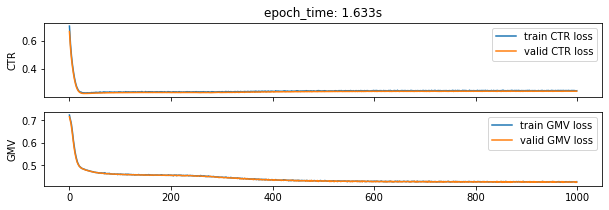

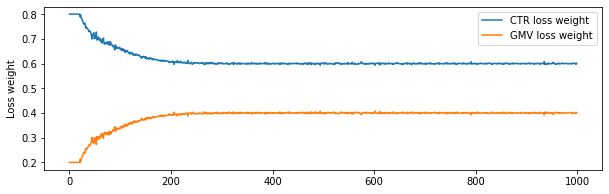

In [22]:
fig,axs = plt.subplots(nrows=2, figsize=(10,3),sharex=True)
axs[0].plot(training['train'][0],label='train CTR loss')
axs[0].plot(training['valid'][0],label='valid CTR loss')
axs[0].set_ylabel('CTR')
axs[1].plot(training['train'][1],label='train GMV loss')
axs[1].plot(training['valid'][1],label='valid GMV loss')
axs[1].set_ylabel('GMV')

axs[0].legend()
axs[1].legend()
axs[0].set_title(f"epoch_time: {np.mean(training['time']):.3f}s")
plt.show()
                 
fig,axs = plt.subplots(figsize=(10,3))
axs.plot(training['w'][0][:1000],label='CTR loss weight')
axs.plot(training['w'][1][:1000],label='GMV loss weight')
axs.set_ylabel('Loss weight')
axs.legend()
plt.show()